In [1]:
import os

from tqdm import tqdm
import numpy as np

import pycolmap

import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [2]:
data = "/Volumes/Extreme_SSD/MegaDepth"

scene = "5018"

location = "Colony on Mathildenhöhe, Darmstadt"


name = f"{scene}-sfm-mvs"
base_name = "baseline"
# base_name = "superpoint_max-superglue-netvlad-50"

# super_name = "loftr-netvlad-50-KA+BA"
# super_name = "superpoint_max-superglue-netvlad-50-KA+BA"
# super_name = "superpoint_max-superglue-netvlad-50"
# super_name = "superpoint_max-superglue-exhaustive-KA+BA"

super_name = "disk_lg+sift+splg"


base_sfm_movie = os.path.join(data, "scenes", scene, "visualizations", base_name, "sfm.mp4")
super_sfm_movie = os.path.join(data, "scenes", scene, "visualizations", super_name, "sfm.mp4")

base_mvs_movie = os.path.join(data, "scenes", scene, "visualizations", base_name, "mvs.mp4")
super_mvs_movie = os.path.join(data, "scenes", scene, "visualizations", super_name, "mvs.mp4")

In [3]:
base_model = pycolmap.Reconstruction(os.path.join(data, "scenes", scene, "sparse", base_name))
super_model = pycolmap.Reconstruction(os.path.join(data, "scenes", scene, "sparse", super_name))

print(base_model.summary())
print(super_model.summary())

Reconstruction:
	num_reg_images = 79
	num_cameras = 1
	num_points3D = 14119
	num_observations = 75412
	mean_track_length = 5.34117
	mean_observations_per_image = 954.582
	mean_reprojection_error = 0.948331
Reconstruction:
	num_reg_images = 79
	num_cameras = 2
	num_points3D = 85066
	num_observations = 519844
	mean_track_length = 6.11107
	mean_observations_per_image = 6580.3
	mean_reprojection_error = 0.966188


In [4]:
num_images = os.listdir(os.path.join(data, "scenes", scene, "images"))
num_images = len(num_images)
num_images

79

In [5]:
num_images = 5386

In [6]:
def get_summary_txt(model: pycolmap.Reconstruction, num_images) -> str:
    txt = f"Number of registered images:   {model.num_reg_images():.0f}\n"
    txt += f"% of registered images:              {model.num_reg_images() / num_images * 100:.1f}%\n"
    txt += f"Number of points:                        {model.num_points3D():.0f}\n"
    txt += f"Mean observations per image:  {model.compute_mean_observations_per_reg_image():.1f}\n"
    txt += f"Mean track length:                       {model.compute_mean_track_length():.1f}\n"
    txt += f"Mean reprojection error:             {model.compute_mean_reprojection_error():.4f}\n"
    return txt

In [7]:
# load the videos as numpy arrays
cap1 = cv2.VideoCapture(super_sfm_movie)
cap2 = cv2.VideoCapture(super_mvs_movie)

# get resolution
width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

width, height

(1920, 1080)

In [8]:
frame1 = cap1.read()[1]
frame2 = cap2.read()[1]

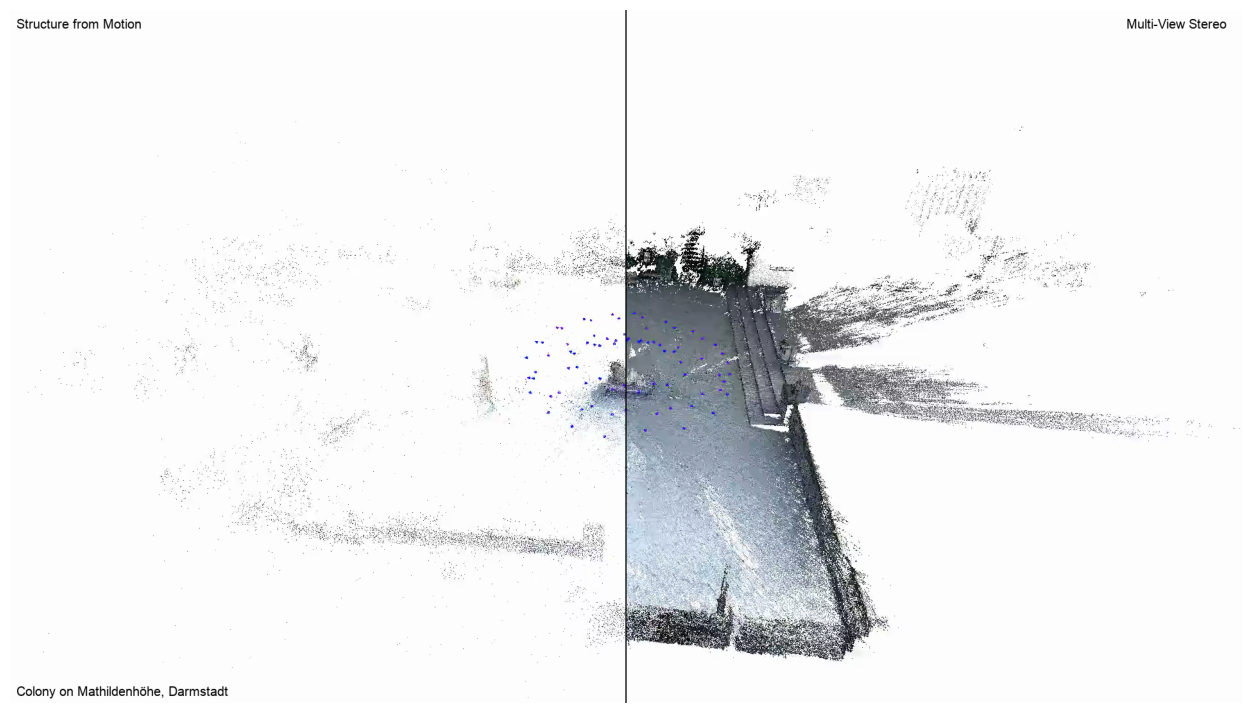

In [9]:
frame = np.zeros((height, width, 3), np.uint8)

frame[:, :width//2, :] = frame1[:, :width//2, :]
frame[:, width//2:, :] = frame2[:, width//2:, :]

frame[:, width//2-1:width//2+1, :] = [0, 0, 0]

# add text to the frame using PIL

def add_text_to_frame(frame, location, base_model, super_model):
    pil_frame = Image.fromarray(frame)
    draw = ImageDraw.Draw(pil_frame)
    font = ImageFont.truetype("Arial.ttf", 20)

    draw.text((10, 10), "Structure from Motion", font=font, fill=(0, 0, 0))
    draw.text((width-180, 10), "Multi-View Stereo", font=font, fill=(0, 0, 0))
    draw.text((10, height - 30), f"{location}", font=font, fill=(0, 0, 0))

    # add model summary
    # font = ImageFont.truetype("Arial.ttf", 16)
    # draw.text((10, 40), f"{get_summary_txt(base_model, num_images)}", font=font, fill=(0, 0, 0))
    # draw.text((width-330, 40), f"{get_summary_txt(super_model, num_images)}", font=font, fill=(0, 0, 0))
    return np.array(pil_frame)


frame = add_text_to_frame(frame, location, base_model, super_model)


 
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(frame)
plt.axis("off")
plt.show()

In [10]:
# load the videos as numpy arrays
cap1 = cv2.VideoCapture(super_sfm_movie)
cap2 = cv2.VideoCapture(super_mvs_movie)

# get resolution
width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

i = 0

pbar = tqdm(total=1200)

while cap1.isOpened() and cap2.isOpened():

    if i >= 1200:
        break

    frame = np.zeros((height, width, 3), np.uint8)

    frame1 = cap1.read()[1]
    frame2 = cap2.read()[1]

    if frame1 is None or frame2 is None:
        break

    if i == 0:   
        for j in range(300):
            frame = np.zeros((height, width, 3), np.uint8)
            # move split view middle to left to right to middle
            shift = np.sin(j/300 * 2* np.pi)
            split = int(width/2 + shift * width/2)
            frame[:, :split, :] = frame1[:, :split, :]
            frame[:, split:, :] = frame2[:, split:, :]

            # add vertical line
            frame[:, split-1:split+1, :] = 0

            # save frame
            frame = add_text_to_frame(frame, location, base_model, super_model)
            cv2.imwrite(os.path.join(data, "movies", f"{name}{i}.png"), frame)

            i += 1
            pbar.update(1)
    elif i == 600:
        for j in range(300):
            frame = np.zeros((height, width, 3), np.uint8)
            # move split view middle to left to right to middle
            shift = np.sin(j/300 * 2* np.pi)
            split = int(width/2 + shift * width/2)
            frame[:, :split, :] = frame1[:, :split, :]
            frame[:, split:, :] = frame2[:, split:, :]

            # add vertical line
            frame[:, split-1:split+1, :] = 0

            # save frame
            frame = add_text_to_frame(frame, location, base_model, super_model)
            cv2.imwrite(os.path.join(data, "movies", f"{name}{i}.png"), frame)

            i += 1
            pbar.update(1)
    else:
        frame = np.zeros((height, width, 3), np.uint8)

        frame[:, :width//2, :] = frame1[:, :width//2, :]
        frame[:, width//2:, :] = frame2[:, width//2:, :]

        frame[:, width//2-1:width//2+1, :] = 0

        # save frame
        frame = add_text_to_frame(frame, location, base_model, super_model) 
        cv2.imwrite(os.path.join(data, "movies", f"{name}{i}.png"), frame)

        i += 1
        pbar.update(1)

        
cap1.release()
cap2.release()

pbar.close()

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|█████████▉| 1199/1200 [00:51<00:00, 23.44it/s]


In [11]:
# make video
os.system(f"ffmpeg -r 30 -i {os.path.join(data, 'movies', f'{name}%d.png')} -vcodec libx264 -crf 25  -pix_fmt yuv420p {os.path.join(data, 'movies', f'{name}.mp4')} -y")

# remove images
for i in range(1200):
    try:
        os.remove(os.path.join(data, "movies", f"{name}{i}.png"))
    except:
        pass

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 15.0.7
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1687155014693/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1687155014693/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enab